Tesztelő szkript letöltése, importok.

In [ ]:
# Download tester
!rm annbsc24_p1_hw2_tester.py
!wget https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_tester.py

import os
import tarfile
import PIL
from PIL import Image
import io
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms


import skimage as ski
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from annbsc24_p1_hw2_tester import Tester
tester = Tester()


--2024-05-19 21:10:31--  https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_tester.py
Resolving nipg12.inf.elte.hu (nipg12.inf.elte.hu)... 157.181.160.172
Connecting to nipg12.inf.elte.hu (nipg12.inf.elte.hu)|157.181.160.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12599 (12K)
Saving to: ‘annbsc24_p1_hw2_tester.py’

annbsc24_p1_hw2_tes 100%[===================>]  12.30K  --.-KB/s    in 0.04s   

2024-05-19 21:10:32 (310 KB/s) - ‘annbsc24_p1_hw2_tester.py’ saved [12599/12599]



Letöltjük a PASCAL VOC adatbázis egy összecsomagolt részhalmazát. A képeket és a hozzájuk tartozó szegmentációs címkéket tartalmazó fájlok együttes mérete 60 megabájt körüli, néhány másodpercet igénybe vehet a letöltése a futtatókörnyezet tárhelyére. Az alábbi parancs nem tölti le a fájlt, ha az már jelen van a tárhelyen. Előfordul, hogy a tárhelyen elérhetők maradnak a fájlok akkor is, ha a futtatókörnyezetről lekapcsolódunk, de ez nem garantált.

In [ ]:
!wget -nc https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_data.tar

File ‘annbsc24_p1_hw2_data.tar’ already there; not retrieving.



Az adatbázis beolvasása.

In [ ]:
jpg_ims = []
label_ims = []

# unpacking tar content directly into memory and decoding jpg/png images from there to avoid working with many small files on disk
with tarfile.open("annbsc24_p1_hw2_data.tar", "r") as tar:
    tar_members = tar.getmembers()
    tar_jpg_members = [member for member in tar_members if member.name[-4:] == '.jpg']  # list only jpg images, not label images
    for jpg_member in tar_jpg_members:
        filename_noext = os.path.split(jpg_member.name)[-1][:-4]

        # get next jpg image
        file_in_tar = tar.extractfile(jpg_member)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        jpg_ims.append(npy_image)

        # get label image corresponding to the jpg image
        label_member_name = 'PascalVOC_annbsc_data/SegmentationClass/' + filename_noext + '.png'
        file_in_tar = tar.extractfile(label_member_name)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))  # using PIL instead of cv2 as it supports loading palette coded png images as single channel integer arrays
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        label_ims.append(npy_image)

jpg_ims = np.stack(jpg_ims, axis=0)
label_ims = np.stack(label_ims, axis=0)

# removing 'border region' (255) from label images and replacing it with background (0)
label_ims[label_ims == 255] = 0

print("Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes:", jpg_ims.shape, label_ims.shape)


Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes: (2913, 240, 320, 3) (2913, 240, 320)


**Adatbázis:** A feladat során a Pascal VOC adatbázis egy csökkentett felbontású részhalmazával kell dolgozni. Az adatbázisban húsz kategóriába (plusz "háttér") sorolt objektumokról készült képek vannak. A színes képekhez azonos felbontású szegmentációs címke tartozik, mely minden pixelre meghatározza annak szemantikus kategóriáját.

Az (n_images, size_y=240, size_x=320, n_channels=3) alakú, `np.uint8` adattípusú `jpg_ims` tömb tartalamazza a különböző állatokról, emberekről, járművekről és egyéb tárgyakról készült képeket. A `label_ims` tömb az említett képekhez rendelt szegmentációs címkéket tárolja. Ennek alakja (n_images, size_y=240, size_x=320), adattípusa ugyancsak `np.uint8`. Az egy-egy képhez tartozó szegmentációs címke, a színes képekkel megegyező felbontású egycsatornás kép, mely minden egyes pixelre megadja az ahhoz rendelt szemantikus kategóriát egy integer formájában. Az adatbázis húsz fajta objektumot (élőlényt/tárgyat) különböztet meg, ezek 1 és 20 közti egész számokkal vannak reprezentálva. Azok a pixelek, melyek egyik kiemelt objektumtípushoz sem tartoznak, a "háttér" (background) kategóriába soroltak és 0 értéket kapnak a szegmentációs címkén.

###**A**: Képek kirajzolása az adatbázisból

Elsőként belenézünk a letöltött adatbázis tartalmába.
- **Rajzolj ki néhány képet és az azokhoz tartozó szegmentációs címkét** a `jpg_ims` és `label_ims` tömbökből! Figyelj rá, hogy a kirajzolt címkeképeken elkülöníthetőek legyen az objektumok a háttértől!
- **Írd a képek fölé, hogy milyen kategóriájú objektumok találhatók meg rajtuk**, pl. így: "[boat, horse, sheep]"! A kategóriák neveinek listája a következő kódblokkban az `ORIG_CAT_NAMES` változóban található. Hagyd ki a "háttér" (background) kategóriát a felsorolásból, hiszen az szinte mindegyik képen jelen van!

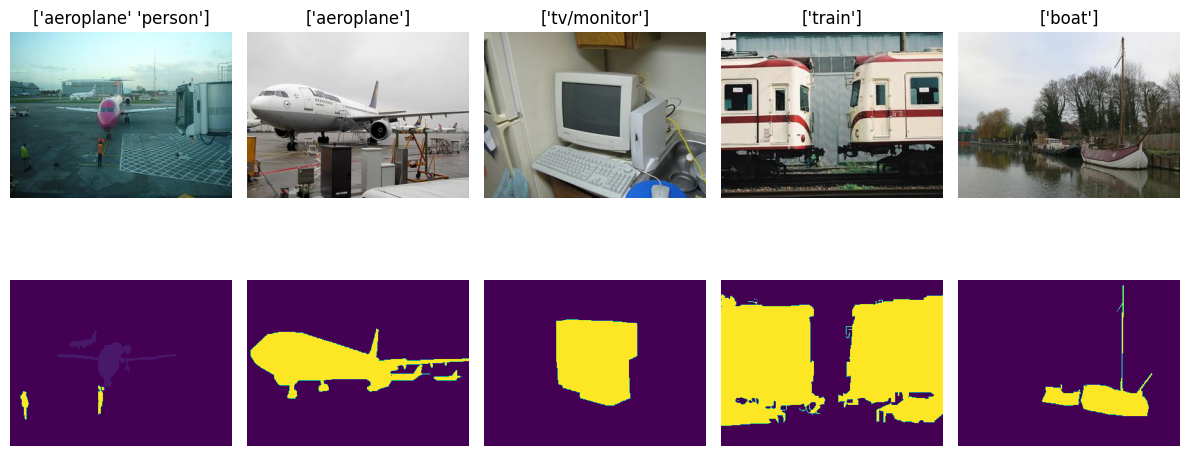

In [ ]:
ORIG_CAT_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
#                         0          1         2         3       4           5     6       7        8   9         10       11            12    13        14          15            16           17       18       19      20
# implement your solution BELOW

np_labels = np.array(ORIG_CAT_NAMES[1:])

plt.figure(figsize=(12, 6))

for i in range(5):
  img = jpg_ims[i]
  limg = label_ims[i]

  mask = np.isin(np.arange(1,21), limg)
  labels = np_labels[mask]

  plt.subplot(2, 5, i+1)

  plt.imshow(img)
  plt.title(f"{labels}")
  plt.axis('off')

  plt.subplot(2, 5, 5 + i+1)
  plt.imshow(limg)

  plt.axis('off')

plt.tight_layout()
plt.show()




###**B**: Új kategóriák definiálása a klasszifikációhoz, releváns képek kiválogatása

Ahogy az előző cellában, a kategórianevek közt láthattuk, öt fajta háziállat szerepel a szegmentációs kategóriák közt. Ezek: 'cat', 'dog', 'cow', 'horse', 'sheep' (macska, kutya, szarvasmarha, ló, birka). Minden más eredeti kategóriabeli képet az 'other' (egyéb) kategóriába sorolunk együttesen. Ebben a feladatban kiválasztjuk a háziállatokat ábrázoló képeket, valamint a fennmaradó, 'other' kategóriájú képekből kiválasztunk még néhányat, hogy háziállatokat nem tartalmazó negatív példákkal is rendelkezzünk a neuronháló betanításához.

Készítsd el a `relevant_idxs` egydimenziós tömböt, mely azoknak a képekeknek az indexeit fogja tárolni a `jpg_ims` és `label_ims` tömbökből, amelyeket felhasználjuk majd a hálónk betanítása során! Kerüljön bele a `relevant_idxs` tömbbe 200 darab véletlenszerűen választott kép indexe azok közül, ahol egy háziállat kategória sem szerepel, majd az összes olyan képnek az indexe, melyen a háziállat kategóriák közül **pontosan egy** szerepel. Rendezd a képeket a tömbben az új kategóriájuk szerinti sorrendbe így: ['other', 'cat', 'dog', 'cow', 'horse', 'sheep'].

Azaz, a `relevant_idxs` tömbben elhelyezett első 200 index olyan képeket indexel a `jpg_ims` és `label_ims` tömbökből, melyeken nincsenek háziállatok, majd ezután következik az összes olyan kép indexe amelyen macskák vannak, de más háziállat nem, majd az összes olyan kép indexe, melyen kutyák vannak, de más háziállat nem és hasonlóan tovább a szarvasmarhákkal, lovakkal, majd végül a birkákkal.

In [ ]:
# implement your solution BELOW

anim_indexes = np.array([8,12,10,13,17])

bool_mask = np.empty((5, jpg_ims.shape[0]), dtype=bool)
print(bool_mask.shape)

i = 0

for ind in anim_indexes:
  my_mask = (label_ims == ind)
  my_mask = np.any(my_mask, axis=1)
  my_mask = np.any(my_mask, axis=1)

  bool_mask[i, :] = my_mask
  i += 1

one_anim_mask = np.sum(bool_mask, axis=0) == 1
zero_anim_mask = np.sum(bool_mask, axis=0) == 0

nanim_idxs = np.arange(jpg_ims.shape[0])[zero_anim_mask]
anim_idxs = np.arange(jpg_ims.shape[0])[one_anim_mask]

chosen_indices = np.random.choice(nanim_idxs.shape[0], size=200, replace=False)
chosen_idxs = nanim_idxs[chosen_indices]

relevant_idxs = np.concatenate((chosen_idxs, anim_idxs))

# implement your solution ABOVE

tester.test('B', relevant_idxs)

(5, 2913)
Tester: Relevant image indices (Task B) OK


###**C**: Objektum bounding box-ok meghatározása

Azért, hogy könnyítsük a hálónk feladatát és csökkentsük a betanítási időt, a képeket nem egy az egyben adjuk be a neuronhálónknak. Helyette, mivel szegmentációs (pixel szintű) címkék is rendelkezésre állnak a képeinkhez, először azonosítjuk a számunkra fontos objektumok (pl. háziállatok) elhelyezkedését a képeken és az egyes objektumok körül felvett négyzetek segítségével egységes, kisebb méretű képrészleteket vagdosunk ki. Ezek a képrészletek alkotják majd a tanításhoz és kiértékeléshez használt adathalmazunkat.

Ebben a részfeladatban azonosítanod kell a tanításhoz felhasználható objektumok elhelyezkedését, méghozzá azok bounding box-ainak (bennfoglaló téglalapjainak) megadásával. Egy bounding box az a téglalap, mely egy képen található objektumot körülvesz úgy, hogy az objektumhoz tartozó minden pixel a téglalap belsejében, vagy a határoló vonalakon található, a téglalap minden oldalát határoló vonal lefed legalább egy-egy, az objektumhoz rendelt pixelt és a téglalap oldalai párhuzamosak az x vagy y tengelyekkel. Példa az ábrákon:

<img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/bbox.jpg' width='25%'>
<img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/bbox3.png' width='27%'>


A képeken több azonos kategóriájú objektum lehet. Egy objektumot a szegmentációs címkén egy adott értékű összefüggő terület határoz meg. A különböző, összefüggő objektumok elkülönítéséhez segítséget ad a HF2 GYIK fórum.

Készítsd el az `(n_bounding_box, 6)` alakú, integer adattípusú `bboxes` tömböt, mely a `relevant_idxs` által megadott képeken megtalálható objektumokhoz tartalmazza azok bounding box-ának adatait (*)! Minden bounding box-hoz hat értéket tárolunk el. Ezek sorban:
* A téglalap felső oldalának y koordinátája
* A téglalap bal oldalának x koordinátája
* A téglalap alsó oldalának y koordinátája
* A téglalap jobb oldalának x koordinátája
* A tartalmazott objektum (új) kategóriája. Az új kategória az előző feladatban megadott kategóriaindexek, tehát a 0, 1, 2, 3, 4, 5 számok egyike lehet.
* A kapcsolódó kép indexe a `jpg_ims`/`label_ims` tömbökben.

(*) A `bboxes` tömbbe ne kerüljenek bele olyan nem-háziállat objektumok bounding box-ai, melyek háziállatokat tartalmazó képeken vannak! Nem-háziállat objektumok bounding box-ait tehát csak az első 200 képről szedjünk ki, a többi (háziállat kategóriájú) képről pedig csak a háziállatok bounding box-ait gyűjtsük össze! Ezt azért tesszük, hogy ne tévesszük meg a hálónkat ellentmondásos esetekkel: ha a képen háziállat látható, semmiképpen ne kerüljön az "other" kategóriába az.

In [ ]:
# implement your solution BELOW

#not animal

MAX = 10000

bboxes = np.empty((MAX, 6), dtype=int)

print(relevant_idxs.shape)

counter = 0
bbox_counter = 0

for index in relevant_idxs:
  if(counter % 50 == 0):
    print(counter)

  img = jpg_ims[index]
  label = label_ims[index]

  cucc = ski.measure.label(label)
  category = 0

  #if animal image
  if counter >= 200:
    unique_numbers = np.unique(label)
    animal_number = np.intersect1d(anim_indexes, unique_numbers)
    category = np.where(anim_indexes == animal_number)[0][0] + 1


  for x in range(np.amax(cucc)):
    min_row_index = np.where(cucc == x+1)[0].min()
    max_row_index = np.where(cucc == x+1)[0].max()
    min_column_index = np.where(cucc == x+1)[1].min()
    max_column_index = np.where(cucc == x+1)[1].max()

    # if object on an animal image
    if counter >= 200:
      cp_unique_numbers = np.unique(label[min_row_index:max_row_index, min_column_index:max_column_index])
      cp_animal_number = np.intersect1d(anim_indexes, cp_unique_numbers)
      if len(cp_animal_number) == 0:
        continue

    bboxes[bbox_counter] = [
        min_row_index,
        min_column_index,
        max_row_index,
        max_column_index,
        category,
        index
      ]

    bbox_counter += 1

  counter += 1


bboxes = bboxes[0:bbox_counter]

print(bboxes.shape)


# implement your solution ABOVE

tester.test('C', bboxes)

(1067,)
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
(5794, 6)
Tester: Bounding boxes (Task C) OK


###**D**: Képek kirajzolása objektum bounding box-okkal

- Válassz ki véletlenszerűen néhány képet melyekhez tartoznak bounding box-ok (a `bboxes` tömb alapján), rajzold ki ezeket a képeket és rajzold rájuk a hozzájuk tartozó összes bounding box-ot! Rajzold ki **piros színnel** a bounding box téglalapját, ha az egy háziállathoz tartozik és rajzold ki **sárga színnel**, ha az egyéb kategóriájú objektumhoz tartozik!
- Téglalap rajzolásához a matplotlib könyvtárban a `matplotlib.patches.Rectangle` osztály példányosítható, majd ez hozzáadható egy grafikonhoz (Axes-hez) a `matplotlib.axes.Axes.add_patch()` függvénnyel.

_**Megjegyzés**: Ha az előző feladatot jól csináltad, nem kaphatsz olyan képeket itt, melyen sárga és piros téglalapok egyszerre szerepelnek._

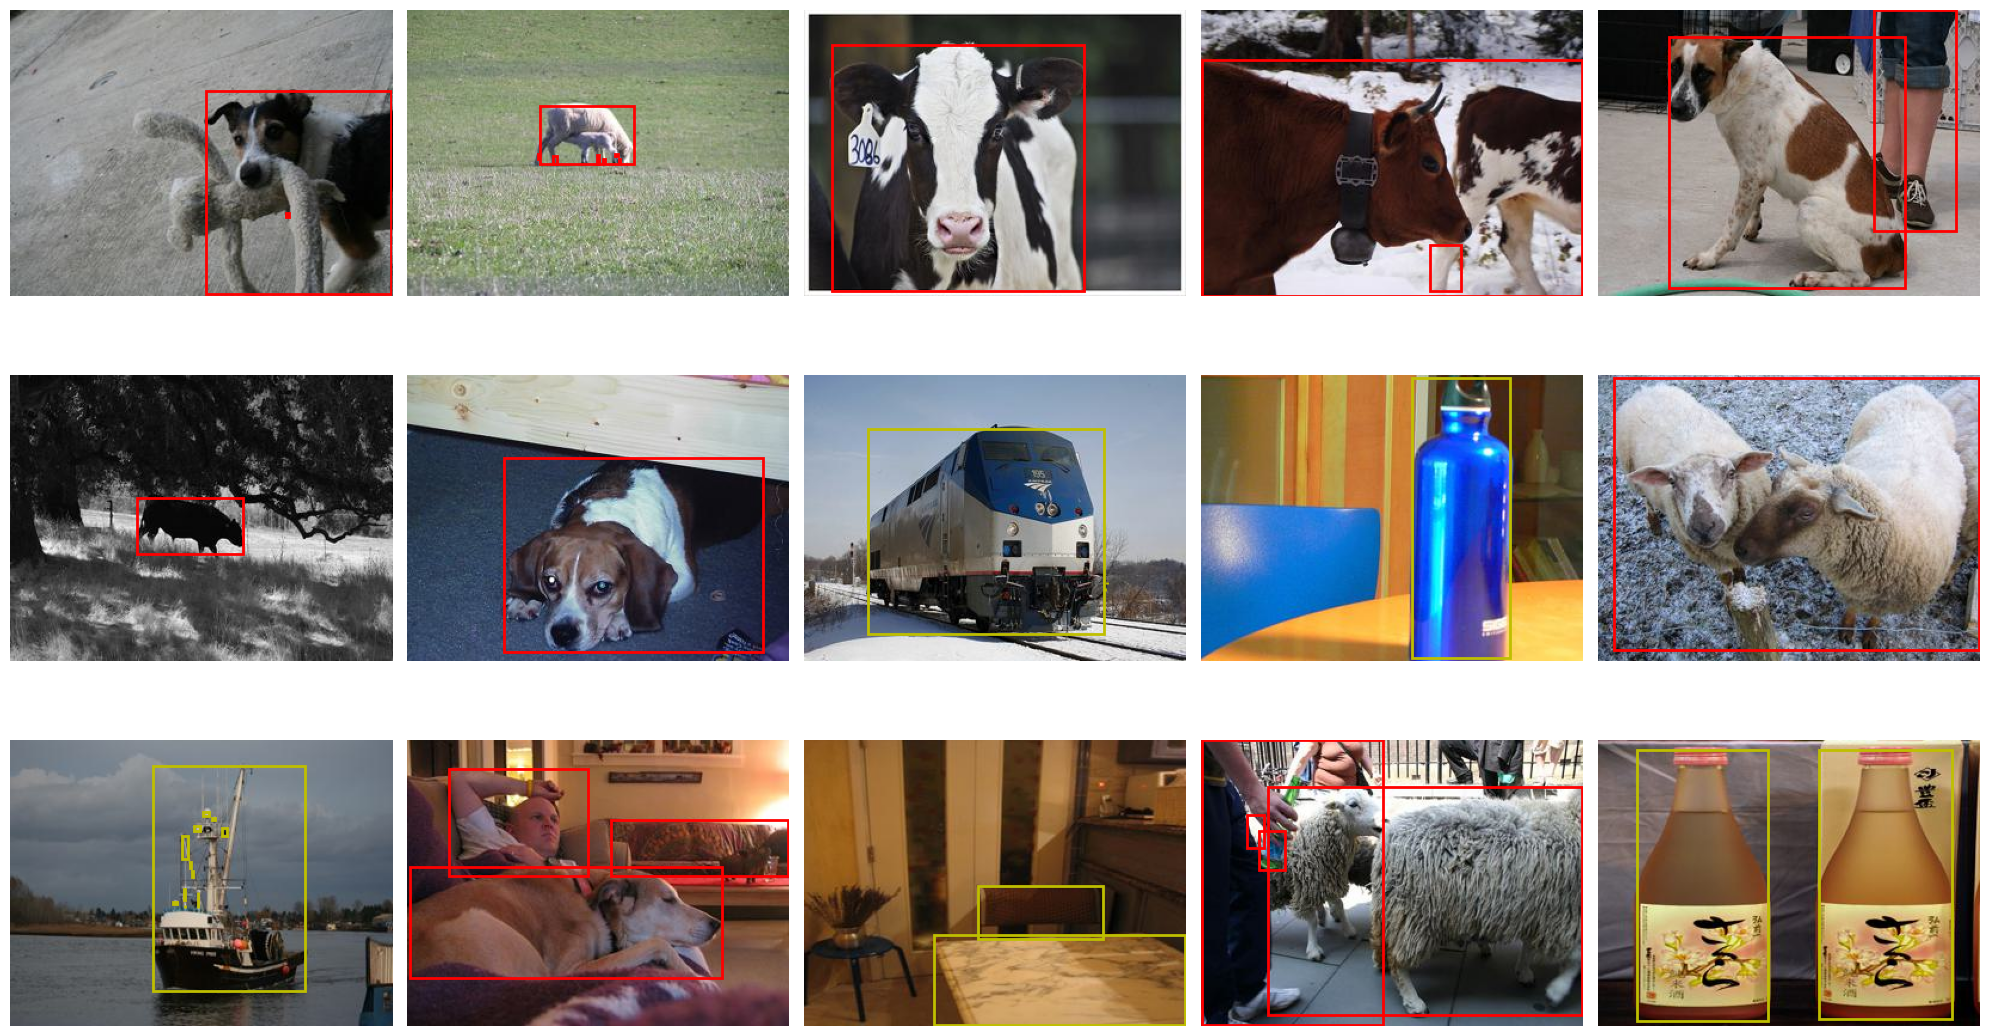

In [ ]:
# implement your solution BELOW

N = 15

selected_indices = np.random.choice(relevant_idxs.shape[0], size=N, replace=False)

plt.figure(figsize=(20, 15))

for id in range(len(selected_indices)):

  plt.subplot(N // 5 + 1,  5, id+1)

  index = relevant_idxs[selected_indices[id]]

  ax = plt.gca()  # magic

  img = jpg_ims[index]
  ax.imshow(img)

  mask = bboxes[:,5] == index
  boxes = bboxes[mask]

  for bbox in boxes:
    y_min, x_min, y_max, x_max, category, _ = bbox
    if category != 0:
      rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    else:
      rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

  plt.axis('off')

plt.tight_layout()
plt.show()






###**E**: A betanításhoz felhasznált képek és címkék elkészítése

Ebben a feladatban a bounding box-aink környezetéből fogunk négyzet alakú, 160 x 160 pixel felbontású képrészleteket kivágni. Ezek fogják adni majd a neuronhálónk tanító-, validációs- és teszthalmazait. A kivágás módja a következő lesz:

  - A túlzottan kicsi objektumokkal nem foglalkozunk most. Dobd el azokat a bounding box-okat, melyeknek a területe kisebb, mint 1000 pixel!
  - Vedd a megmaradt bounding box-ok középpontjait és vágj ki ugyanezekkel a középpontokkal egy-egy 160 x 160 pixel felbontású négyzetet a képekből!
  - Amennyiben a kivágott kép lelóg az eredeti képről, a lelógó részeket színezd egységesen feketére a kivágott képen, ahogy az az alábbi ábrán is látható:

    <img src='https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/annbsc24_p1_hw2_imcrop2.jpg' width='50%'>

A fenti módszerekkel kapott 160 x 160 felbontású képeidet helyezd el az `(n_cropped_images, sy=160, sx=160, n_channels=3)` alakú `xs` tömbbe, ahol `n_cropped_images` az így elkészült kivágott képrészletek számát jelöli! A tömb adattípusa maradjon az eddigi, `uint8`! Készítsd el a tanításhoz felhasználható címkéket tartalmozó tömböt is: legyen `ys` (n_cropped_images,) alakú, integer adattípusú tömb, mely megadja az egyes kivágott képekhez, azok kategóriáját az új hat kategóriás besorolás szerint! Az `ys` tömb elemei, tehát, a 0, 1, 2, 3, 4, 5 értékek lehetnek és sorban az 'other', 'cat', 'dog', 'cow', 'horse', 'sheep' kategóriákat reprezentálják.

In [ ]:
# implement your solution BELOW

img_size_x = 320
img_size_y = 240

xs = np.empty((len(bboxes),160,160,3), dtype=np.uint8)
ys = np.empty((len(bboxes)), dtype=np.uint8)

counter = 0;
for bbox in bboxes:
  y_min, x_min, y_max, x_max, category, img_idx = bbox

  img = jpg_ims[img_idx]

  width = x_max - x_min + 1
  height = y_max - y_min + 1

  if width * height < 1000:
    continue

  c_x = (x_max + x_min) // 2
  c_y = (y_max + y_min) // 2

  cropped_image = np.zeros((160, 160, 3), dtype = np.uint8)

  x_start = max(0, c_x - 80)
  y_start = max(0, c_y - 80)
  x_end = min(img_size_x, c_x + 80)
  y_end = min(img_size_y, c_y + 80)

  # print(x_start, y_start, x_end, y_end)

  x_start_crop = 80 - (c_x - x_start)
  y_start_crop = 80 - (c_y - y_start)
  x_end_crop = x_start_crop + (x_end - x_start)
  y_end_crop = y_start_crop + (y_end - y_start)

  # print(x_start_crop, y_start_crop, x_end_crop, y_end_crop)

  crop = img[y_start:y_end, x_start:x_end]
  # print(cc.shape)

  cropped_image[y_start_crop:y_end_crop, x_start_crop:x_end_crop] = crop
  # print(dd.shape)

  xs[counter] = cropped_image
  ys[counter] = category
  counter += 1


xs = xs[0:counter]
ys = ys[0:counter]
print(ys.shape)


# implement your solution ABOVE

tester.test('E', xs, ys)

(1906,)
Tester: Image cropping & category labels (Task E) OK


###**F**: Keverés és felbontás tanító-, validációs- és teszthalmazra

- Keverjük meg konzisztensen a képeket (`xs`) és a kategóriacímkéket (`ys`). Ez szükséges, hiszen a két tömböt valószínűleg úgy állítottuk elő az előző kódblokkban, hogy a kategóriacímkék sorban következnek egymás után, így a tanító-, validációs- és teszthalmazra való felbontásnál előfordulna olyan kategória, amelyik csak az egyik halamzban lenne jelen. Két tömb azonos sorrendű keveréséhez használható egy közös, véletlenszerűen megkevert indextömb például.
- Bontsuk fel tanító-, validációs- és teszthalmazra a két tömböt! Használjunk 60%/20%/20%-os felosztást! Állítsuk elő így az `xs_train`, `xs_val`, `xs_test` inputokat (képeket) és `ys_train`, `ys_val`, `ys_test` címkéket tartalmazó tömböket!

In [ ]:
# implement your solution BELOW


perm = np.random.permutation(xs.shape[0])
xs = xs[perm,...]
ys = ys[perm]

split0 = int(xs.shape[0]*0.6)
split1 = int(xs.shape[0]*0.8)

xs_train  = xs[       : split0  ,...]
xs_val    = xs[split0 : split1  ,...]
xs_test   = xs[split1 :         ,...]

ys_train  = ys[       : split0]
ys_val    = ys[split0 : split1]
ys_test   = ys[split1 : ]

# implement your solution ABOVE

tester.test('F', xs_train, xs_val, xs_test, ys_train, ys_val, ys_test)

Tester: Dataset split (Task F) OK


###**G**: Az adat-iterátorok létrehozása a képklasszifikációs feladathoz, adat-augmentáció

Az első házi feladathoz és zárthelyihez hasonlóan, ezúttal is iterátorokkal oldjuk meg a neuronhálónk betanítását. Ebben a részfeladatban **elő kell állítanod három iterátor objektumot** `dataloader_train`, `dataloader_val` és `dataloader_test` néven, melyek az előző részfeladatban elkészített tanító-, validációs- és teszthalmazokat tartalmazó input képeket és klasszifikációs címkéket tartalmazó két-két tömböt járják be. **Az iterátorok minden lépésben két tenzort adnak vissza**, melyek egy-egy kötegnyi input képet és az azokhoz tartozó klasszifikációs címkéket tartalmaznak.

A képek esetén szükséges lesz a tengelyek sorrendjének átrendezése, mivel a csatornákat felsoroló tengely eddig hátul volt (_channel-last_ formátum), de a PyTorch erre a tengelyre közvetlenül a kötegméret tengely után számít (_channel-first_ formátum). Ebből kifolyólag, a visszaadott tenzorok alakja `(batch_size, 3, 160, 160)` és `(batch_size,)` lesz. Előbbi a színes képeket tartalmazza változatlan felbontással, utóbbi a képekhez tartozó kategóriaindexeket. `batch_size` a mintaelemek számát adja meg, melyeket egyszerre, egy kötegben fog megkapni a neuronhálónk - ennek értéke lehet például 32.

Hangsúlyozandó, hogy az iterátorok a fent említett NumPy tömbökből (`np.ndarray`) nyert mintaelem-kötegeket már `torch.tensor` típusú objektumokként adják vissza (pontosabban, kételemű tuple-öket adnak vissza, melyekben `torch.tensor` objektumok lesznek). A PyTorch-al definiált neuronhálók betanításához már mindenképp PyTorch tenzorok szükségesek. Az input tenzor **adattípusa** 4 bájtos lebegőpontos típus (`torch.float32`), a kategóriaindexeket tartalmazó tenzor adattípusa pedig, a PyTorch kívánalmait követve, 8 bájtos előjeles egész típus kell, hogy legyen (`torch.int64`)!

A neuronhálónk egy előtanított mély konvolúciós hálón alapul, ezért a képeinket olyan formátumra kell hoznunk, amilyet a háló a betanításakor látott. Az eredetileg [0, 255] intervallumbeli értékeket tartalmazó képeinket először a [0, 1] intervallumra kell leskáláznunk, majd színcsatornánként megadott átlag (`MOBILENET_MEANS`) és szórás (`MOBILENET_STDS`) értékekkel kell sztenderdizálnunk. Az iterátor által visszaadott képek színcsatornánként függetlenül vett átlaga tehát 0 körül, szórása pedig 1 körül lesz a helyes sztenderdizáció után. Ehhez a művelethez útmutatót a "9. előadás, szoftveres rész - PyTorch képklasszifikáció" notebook-ban / videóban találsz, illetve az alábbi linken: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

Az iterátorok implementációja többféleképpen megoldható, de javasolt a `torch.utils.data` modul `Dataset` és `DataLoader` osztályait felhasználni, vagy szükség esetén származtatni őket.

**Adat-augmentáció:** Sajnos a néhány ezer képből álló adatbázisunkra hamar túltanulna a hálónk és nincs lehetőségünk új tanítóadatot beszerezni, így az adat-augmentálás technikájához kell fordulnunk. Azért, hogy valóban növeljük az adatbázisunkban a képek változatosságát, az adat-augmentációt nem előzetesen alkalmazzuk az egész adatbázison egyben, hanem dinamikusan hajtjuk végre, véletlenszerűen választott transzformációkkal minden újabb mintaelemen, vagy kötegen.

Alkalmazz véletlenszerű adat-augmentációt a **tanító** iterátorban, hogy csökkentsd a túltanulás valószínűségét! Az adat-augmentációs módszerek közt legyen kis méretékű transzláció (eltolás), forgatás, skálázás, illetve a kép színeinek torzítása! A validációs- és teszt-iterátorok ne alkalmazzank adat-augmentációt, hiszen ezeket kiértékeléshez fogjuk használni! Az adat-augmentációhoz javasolt (de nem kötelező) a `torchvision.transforms` modul eszközeit használni. Ennek segítségével a sztenderdizáció is megoldható. A használatára láthatsz példákat a fent említett notebook-ban / videóban és a PyTorch dokumentációjában is.

_**Megjegyzés:** A `torchvision.transforms.Resize` és `torchvision.transforms.CenterCrop` transzformációkra nincs szükség most, hiszen nem akarjuk átméretezni a képeinket már._


In [ ]:
MOBILENET_MEANS = [0.485, 0.456, 0.406]
MOBILENET_STDS = [0.229, 0.224, 0.225]   # MobileNet v2 stats used for image normalization

# implement your solution BELOW



class MarciDataset(Dataset):
    def __init__(self, images, labels, transform=None, device='cpu'):
        self.images = torch.tensor(images, device=device, dtype = torch.float32) / 255
        self.labels = torch.tensor(labels, device=device, dtype = torch.int64)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.permute(image,(2,0,1))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS)
])

eval_transform = transforms.Compose([
    transforms.Normalize(mean=MOBILENET_MEANS, std=MOBILENET_STDS)
])

device = 'cpu'
train_dataset = MarciDataset(xs_train, ys_train, transform=train_transform, device=device)
val_dataset = MarciDataset(xs_val, ys_val, transform=eval_transform, device=device)
test_dataset = MarciDataset(xs_test, ys_test, transform=eval_transform, device=device)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

# implement your solution ABOVE

tester.test('G', dataloader_train, dataloader_val, dataloader_test)

Tester: Dataset iterators (Task G) OK


###**H**: A konvolúciós háló definiálása klasszifikációhoz

A konvolúciós hálónk alapját egy, az ImageNet adatbázison előtanított MobileNet v2 neuronháló adja. Ezt alapul véve (és a tanult súlyainak nagyrészét felhasználva) készítjük el a célfeladat megoldására alkalmas konvolúciós hálónkat, amit finomhangolunk az adatbázisunkon.

**Definiáld a (multi-class) klasszifikációs feladathoz alkalmazandó neuronhálót megvalósító osztályt**, mely az általános `torch.nn.Module` osztály leszármazottja!

Töltsd be a MobileNet v2 neuronhálót előtanított súlyokkal, majd ennek utolsó konvolúciós rétegéhez (`features[17].conv[3]`) fűzz hozzá egy kisméretű neuronhálót, melynek architektúrája alkalmas a feladatunk megoldására!

Egy javaslat a hozzáfűzendő rétegekre:
- Egy konvolúciós réteg nem túl nagyszámú (pl. 32) filterrel.
- Két teljesen összekötött réteg, ahol az utolsó neuronjainak számát a feladat határozza meg.
- A rétegek közt aktivációs függvények vannak (pl. ReLU).

**Példányosítsd az új osztályt** és add értékül a `ft_model` nevű változónak a példányt!

Találsz példákat hasonló kódokra a 8. előadásban és a "9. előadás, szoftveres rész - PyTorch képklasszifikáció" notebook-ban / videóban is.

_**Megjegyzés:** Meggyorsíthatja a betanulást, ha a MobileNet hálóhoz tartozó súlyokat befagyasztod (nem tanítod)._


In [ ]:
# implement your solution BELOW

class ImageClassificationNet(nn.Module):
    def __init__(self, n_class):
        super(ImageClassificationNet, self).__init__()

        self.mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

        for param in self.mobilenet.parameters():
            param.requires_grad = False

        self.mobilenet.features = nn.Sequential(*list(self.mobilenet.features.children())[:18])

        self.additional_layers = nn.Sequential(
            nn.Conv2d(in_channels=320, out_channels=32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, n_class)
        )

    def forward(self, x):
        x = self.mobilenet.features(x)
        x = self.additional_layers(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


n_class = 6
ft_model = ImageClassificationNet(n_class=n_class)


# implement your solution ABOVE

tester.test('H', ft_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tester: Model architecture (Task H) OK


###**I**: Néhány augmentált kép kirajzolása

Azért, hogy lássuk, a hálónk megfelelő inputot és címkéket fog kapni, mintavételezünk pár képet és címkét a G) feladatban elkészített iterátorokból és kirajzoljuk ezeket.
- Mintavételezz néhány képet és a hozzájuk tartozó címkéket a `dataloader_train` és `dataloader_val` iterátorokból, majd rajzold ki ezeket a képeket és írd föléjük a hozzájuk tartozó címkét (például "3")! Mivel az iterátorok a képeket normalizálják és megváltoztatják a tengelysorrendet is, a helyes kirajzoláshoz ezeket a transzformációkat vissza kell csinálni a kirajzolás előtt.

_**Megjegyzés:** Itt tudod ellenőrizni, hogy egyrészt az adat-augmentáció helyes-e, másrészt, hogy helyes kategóriacímkék tartoznak-e a képekhez._

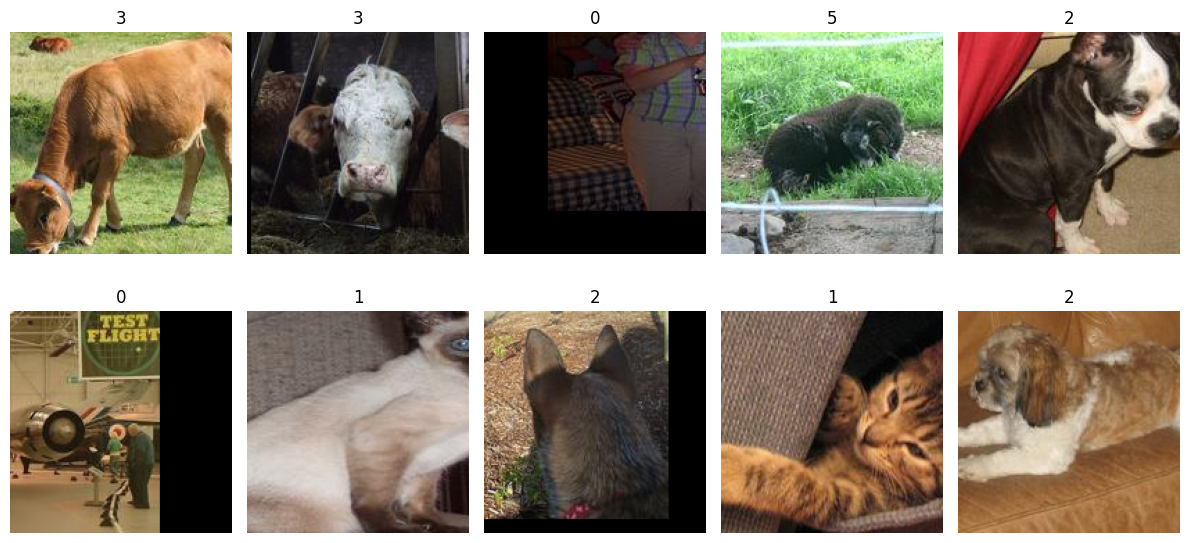

In [ ]:
# implement your solution BELOW

plt.figure(figsize=(12, 6))

j = 0
for dataloader in [dataloader_test, dataloader_val]:
  i = 0
  for imgs, labels in dataloader:
    if(i >= 5):
      break

    random_index = torch.randint(0, imgs.size(0), (1,)).item()
    img = imgs[random_index]
    label = labels[random_index]

    plt.subplot(2, 5, i + 1 + j)
    img = img.permute(1,2,0) * torch.tensor(MOBILENET_STDS) + torch.tensor(MOBILENET_MEANS)
    plt.title(int(label))
    plt.imshow(img)
    plt.axis('off')
    i += 1
  j+=5



plt.tight_layout()
plt.show()



###**J**: A háló betanítása (multi-class) klasszifikációs feladatra

**Tanítsd be az** `ft_model` **neuronhálót** a tanítóhalmazon a `dataloader_train` iterátor segítségével és alkalmazd a `dataloader_val` iterátort a validációhoz!

Alkalmazd a multi-class klasszifikációkor szokásosan használt **cross-entropy költséget**! **Mérd le minden epoch-ban a tanító- és a validációs halmazon mért költségeket, majd a tanítás végeztével rajzold ki ezeknek az értékeknek a tanítás során való alakulását egy közös grafikonon!** A grafikonon a jelmagyarázat meglétére és a görbék könnyű elkülöníthetőségére figyelj ezúttal is! **Számold ki az _accuracy_ (pontosság) metrikát minden epoch-ban a tanító- és a validációs halmazon** és jelöld ezek alakulását is a grafikonon!

A tanítást az **early stopping** technika állítsa le! Amennyiben adott számú epoch-on keresztül (`patience`) nem javul a validációs költség, érjen véget a betanítás és **állítsuk vissza az `ft_model` súlyait abból az epoch-ból, amikor a legjobb volt a validációs költség!** Mindez automatikusan történjen!

A betanítást követően **számold ki az _accuracy_ metrikát a teszthalmaz elemein is** és add értékül a kapott számot a `test_acc` változónak!! Az _accuracy_ metrika a helyesen klasszifikált mintaelemek arányát adja meg. Például, ha 150 mintaelem kategóriájának becslésekor 75 esetben találtuk el a helyes kategóriát, az _accuracy_ értéke 0.5 lesz.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tranining 1/20 done, training loss: 1.9263322353363037, validation loss: 1.23446786403656
Tranining 2/20 done, training loss: 0.960733950138092, validation loss: 0.7346529960632324
Tranining 3/20 done, training loss: 0.7217482924461365, validation loss: 0.6595054268836975
Tranining 4/20 done, training loss: 0.645048975944519, validation loss: 0.6179403066635132
Tranining 5/20 done, training loss: 0.607598066329956, validation loss: 0.6044385433197021
Tranining 6/20 done, training loss: 0.5579288601875305, validation loss: 0.5985696911811829
Tranining 7/20 done, training loss: 0.523239254951477, validation loss: 0.6040017604827881
Tranining 8/20 done, training loss: 0.5192720890045166, validation loss: 0.5766647458076477
Tranining 9/20 done, training loss: 0.46672359108924866, validation loss: 0.5772724747657776
Tranining 10/20 done, training loss: 0.48753854632377625, validation loss: 0.5656156539916992
Tranining 11/20 done, training loss: 0.4415941536426544, validation loss: 0.5631868

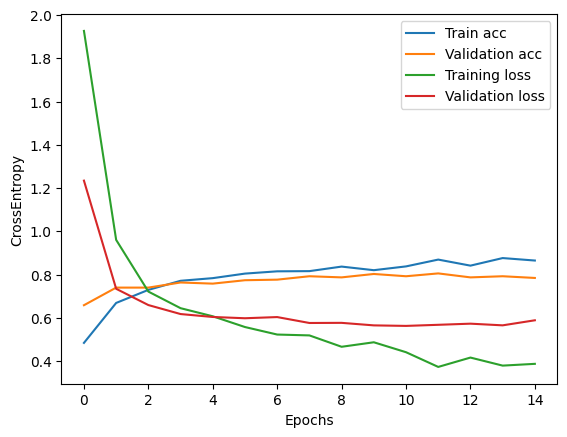

Accuracy:  tensor(0.7513)
Tester: Model training (Task J) OK


In [ ]:
# implement your solution BELOW

def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []

  train_acc = []
  val_acc = []

  best_loss = np.inf
  no_improvement_count = 0

  for epoch in range(n_epochs):
    good = 0
    all = 0
    model.train()
    train_epoch_losses = []

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_hat = model(x)

      good += torch.sum(torch.argmax(y_hat, dim=1) == y)
      all += y_hat.shape[0]

      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)
    train_acc.append(good / all)

    model.eval()
    val_epoch_losses = []
    good = 0
    all = 0

    for x, y in val_dataloader:
      with torch.no_grad():
        y_hat = model(x)

      good += torch.sum(torch.argmax(y_hat, dim=1) == y)
      all += y.shape[0]

      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)
    val_acc.append(good / all)

    if avg_epoch_loss + delta < best_loss:
      best_loss = avg_epoch_loss
      no_improvement_count = 0
      torch.save(model, 'best_model.pth')
    else:
      no_improvement_count += 1

    print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

    if no_improvement_count >= patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', best_loss.item())
      model = torch.load('best_model.pth')
      return train_losses, val_losses, train_acc, val_acc

  model = torch.load('best_model.pth')
  return train_losses, val_losses, train_acc, val_acc




model = ImageClassificationNet(10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, train_acc, val_acc = train(model, dataloader_train, dataloader_val, optimizer, loss_fn, n_epochs=20, patience=5)

plt.plot(train_acc, label="Train acc")
plt.plot(val_acc, label="Validation acc")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()

#metrics

model.eval()

good = 0
all = 0

for x, y in dataloader_test:
    with torch.no_grad():
      y_hat = model(x)

    predictions = torch.argmax(y_hat, dim=1)
    good += torch.sum(predictions == y)
    all += predictions.shape[0]

test_acc = good / all
print('Accuracy: ', test_acc)


# implement your solution ABOVE

tester.test('J', test_acc)

###**K**: Néhány predikció kirajzolása

Végezetül, mintavételezz pár képet a **teszt iterátorból**, becsülj rájuk címkét a betanított modellel, majd rajzold ki a képeket és írd ki föléjük a becsült és a helyes címkét! Hasonlóan az I) részfeladathoz, itt is figyelned kell a képek helyes megjelenítésére!

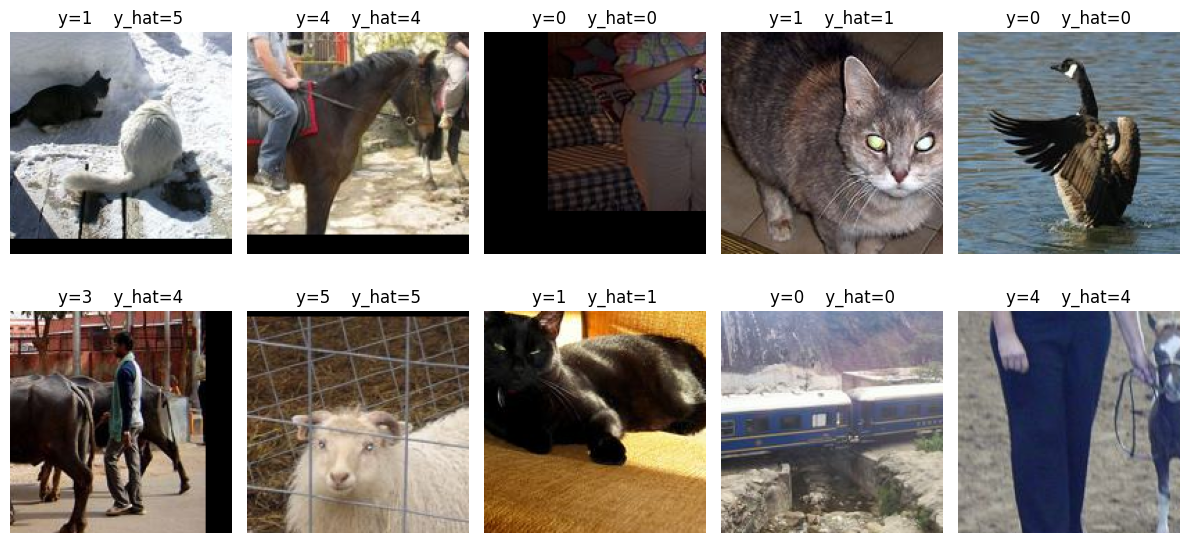

In [ ]:
# implement your solution BELOW


plt.figure(figsize=(12, 6))

# '_SingleProcessDataLoaderIter' object is not callable
# test_iterator = iter(dataloader_test)
# for i in range(10):
#   imgs, labels = next(test_iterator)

i = 0
for imgs, labels in dataloader_test:
  if(i >= 10):
    break

  random_index = torch.randint(0, imgs.size(0), (1,)).item()

  img = imgs[random_index]
  label = labels[random_index]
  with torch.no_grad():
      y_hat = model(img[None,...])
  plt.subplot(2, 5, i + 1)
  img = img.permute(1,2,0) * torch.tensor(MOBILENET_STDS) + torch.tensor(MOBILENET_MEANS)
  plt.title(f"y={int(label)}    y_hat={torch.argmax(y_hat)}")
  plt.imshow(img)
  plt.axis('off')
  i += 1



plt.tight_layout()
plt.show()




